In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

c:\Users\USER\Desktop\TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [71]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '肇因研判大類別名稱-主要', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別',
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

dist_dfA2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] != '未紀錄']
dist_dfA1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] != '未紀錄']

car_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '車的狀態']
car_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '車的狀態']

car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '非駕駛者']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '非駕駛者']
car_A2 = car_A2[car_A2['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']
car_A1 = car_A1[car_A1['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)']

car_A2 = car_A2[car_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
car_A1 = car_A1[car_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']

C:\Users\USER\AppData\Local\Temp\ipykernel_18720\4195921685.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_18720\4195921685.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



篩選掉未紀錄資料以及分類人的狀態以及車的狀態

In [72]:
from sklearn.utils import resample

sampling_ratio = 0.33  # 下採樣比例

# 計算 A1 和 A2 原始數據量比例
A1_total = len(car_A1)
A2_total = len(car_A2)
total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 定義函數，按月份進行下採樣
def downsample_by_month_simple(A1, A2, sampling_ratio, total_ratio):
    A1_downsampled = pd.DataFrame()
    A2_downsampled = pd.DataFrame()

    months = sorted(set(A1['發生月份']).intersection(A2['發生月份']))  # 確保月份匹配

    for month in months:
        # 提取該月份的資料
        A1_month = A1[A1['發生月份'] == month]
        A2_month = A2[A2['發生月份'] == month]

        # 計算該月份目標數量
        A1_target = int(len(A1_month) * sampling_ratio)
        A2_target = int(A1_target / total_ratio)
        print(A1_target)
        print(A2_target)

        # 下採樣
        A1_sampled = resample(A1_month, replace=False, n_samples=A1_target, random_state=42)
        A2_sampled = resample(A2_month, replace=False, n_samples=A2_target, random_state=42)

        # 合併到最終結果
        A1_downsampled = pd.concat([A1_downsampled, A1_sampled])
        A2_downsampled = pd.concat([A2_downsampled, A2_sampled])

    return A1_downsampled.reset_index(drop=True), A2_downsampled.reset_index(drop=True)

# 下採樣
downsampled_A1, downsampled_A2 = downsample_by_month_simple(car_A1, car_A2, sampling_ratio, total_ratio)
# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

45
10705
46
10943
40
9516
36
8564
36
8564
40
9516
48
11419
44
10467
41
9754
48
11419


In [73]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].cat.add_categories('未知')
rbind_data['當事者事故發生時年齡'] = rbind_data['當事者事故發生時年齡'].fillna('未知')

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (101291, 153)


          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.123         2.92%                      2.92%
1              0.113         2.69%                      5.61%
2              0.086         2.05%                      7.66%
3              0.079         1.88%                      9.54%
4              0.074         1.75%                     11.29%
5              0.073         1.72%                     13.01%
6              0.072         1.71%                     14.72%
7              0.070         1.66%                     16.37%
8              0.069         1.64%                     18.01%
9              0.067         1.59%                     19.61%
10             0.064         1.53%                     21.14%
11             0.062         1.48%                     22.62%
12             0.061         1.44%                     24.06%
13             0.057         1.36%                     25.42%
14      

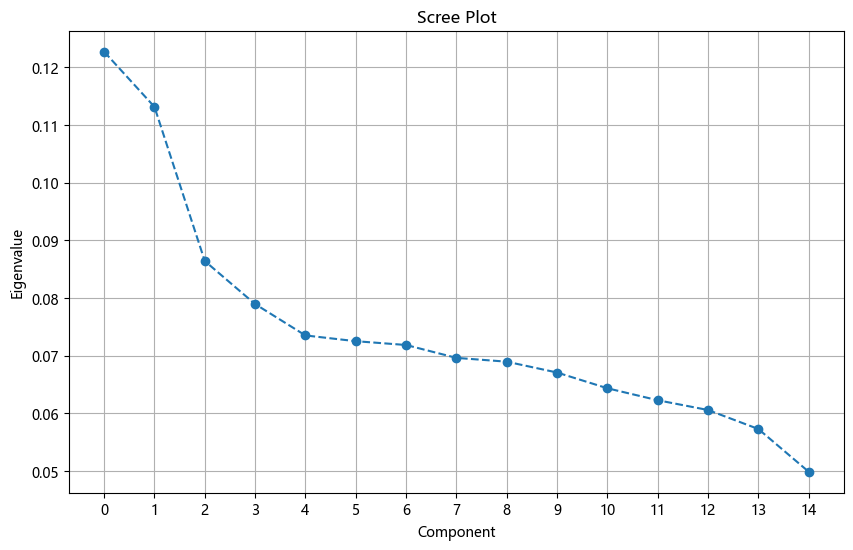

In [77]:
import prince

mca = prince.MCA(
    one_hot=False,
    n_components=15,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

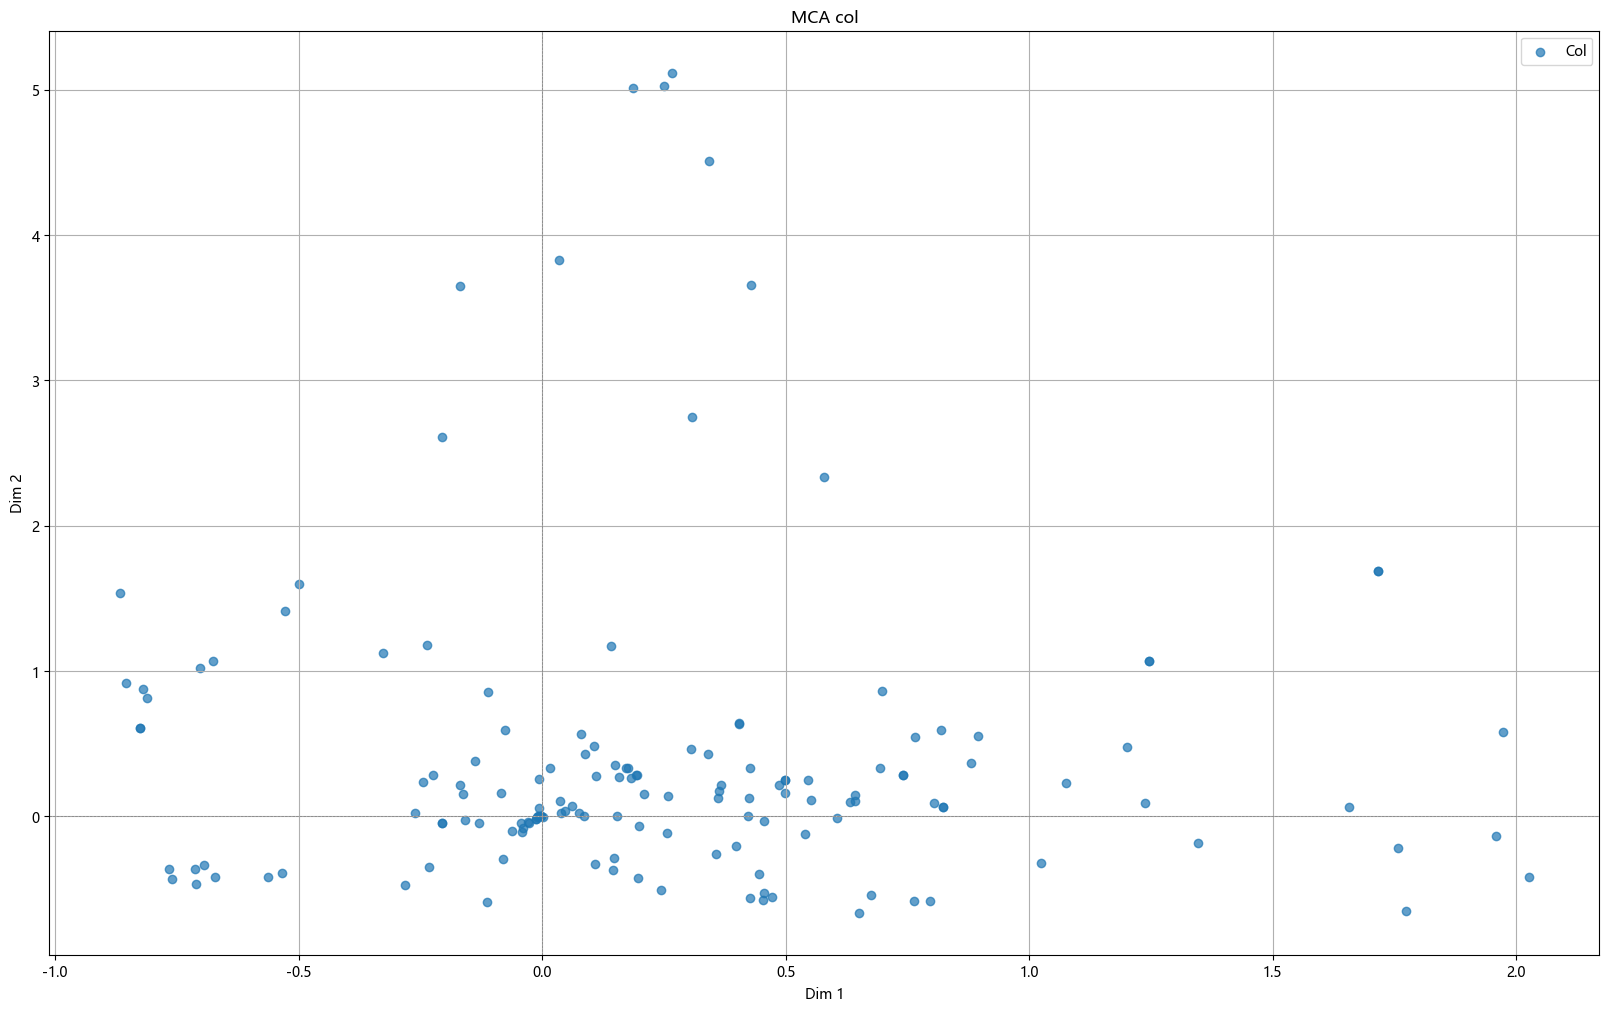

In [79]:
col_coordinate = mca.column_coordinates(data_to_map)
col_coordinate = col_coordinate[col_coordinate[1] < 10]
plt.figure(figsize=(20, 12))
plt.scatter(col_coordinate[0], col_coordinate[1], alpha=0.7, label="Col")

# for i, label in enumerate(col_coordinate.index):
#     plt.text(
#         col_coordinate[0][i], 
#         col_coordinate[1][i], 
#         str(label), 
#         fontsize=10, 
#         ha='right', 
#         va='bottom',
#         rotation=45
#     )

plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title("MCA col")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.legend()
plt.show()

In [80]:
import pickle

detailed_results = []

for overlap in range(3, 6):
    silhouette_for_intervals = []

    for interval in range(6, 11):
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=8
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o{overlap}i{interval}.pkl"
            # filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component11Pass/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 3, interval: 6


Processing Clusters: 100%|██████████| 2506/2506 [00:32<00:00, 77.42it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o3i6.pkl
overlap: 3, interval: 7


Processing Clusters: 100%|██████████| 3704/3704 [00:24<00:00, 148.34it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o3i7.pkl
overlap: 3, interval: 8


Processing Clusters: 100%|██████████| 4910/4910 [00:18<00:00, 271.32it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o3i8.pkl
overlap: 3, interval: 9


Processing Clusters: 100%|██████████| 6287/6287 [00:10<00:00, 578.27it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o3i9.pkl
overlap: 3, interval: 10


Processing Clusters: 100%|██████████| 7940/7940 [00:09<00:00, 828.88it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o3i10.pkl
overlap: 4, interval: 6


Processing Clusters: 100%|██████████| 1512/1512 [01:30<00:00, 16.77it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o4i6.pkl
overlap: 4, interval: 7


Processing Clusters: 100%|██████████| 2290/2290 [01:30<00:00, 25.30it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o4i7.pkl
overlap: 4, interval: 8


Processing Clusters: 100%|██████████| 3139/3139 [00:47<00:00, 65.81it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o4i8.pkl
overlap: 4, interval: 9


Processing Clusters: 100%|██████████| 4058/4058 [00:26<00:00, 154.89it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o4i9.pkl
overlap: 4, interval: 10


Processing Clusters: 100%|██████████| 5267/5267 [00:26<00:00, 197.80it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o4i10.pkl
overlap: 5, interval: 6


Processing Clusters: 100%|██████████| 722/722 [03:49<00:00,  3.14it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o5i6.pkl
overlap: 5, interval: 7


Processing Clusters: 100%|██████████| 1138/1138 [03:05<00:00,  6.15it/s]


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o5i7.pkl
overlap: 5, interval: 8


Processing Clusters: 100%|██████████| 1682/1682 [00:57<00:00, 29.10it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o5i8.pkl
overlap: 5, interval: 9


Processing Clusters: 100%|██████████| 2243/2243 [00:41<00:00, 54.28it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o5i9.pkl
overlap: 5, interval: 10


Processing Clusters: 100%|██████████| 2894/2894 [00:39<00:00, 72.66it/s] 


Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/results_o5i10.pkl


In [81]:
detailed_results_df = pd.DataFrame(detailed_results)
# detailed_results_df.to_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid_halfdata.csv", index=False)

# output_file = '/Users/wangqiqian/Desktop/TrafficTDApython/Version3/Component6Car/full_grid.pkl'
output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/full_grid.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(detailed_results_df, f)

In [8]:
output_file = 'C:/Users/USER/Desktop/TrafficTDApython/Version3/Component15Car/full_grid.pkl'

with open(output_file, 'rb') as f:
    detailed_results_df = pickle.load(f)

In [82]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

from matplotlib.cm import get_cmap
from plots import *

In [ ]:
for choose in rbind_data.columns:
    unique_categories = rbind_data[choose].dropna().unique()
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[2][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=10) # 篩選資料
    mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                        set_label=True, size=100, # 限制點的大小
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o3_i8_{choose}.png")

Mapper plot created.
Data extracted.
Colors mapped using predefined mapping.


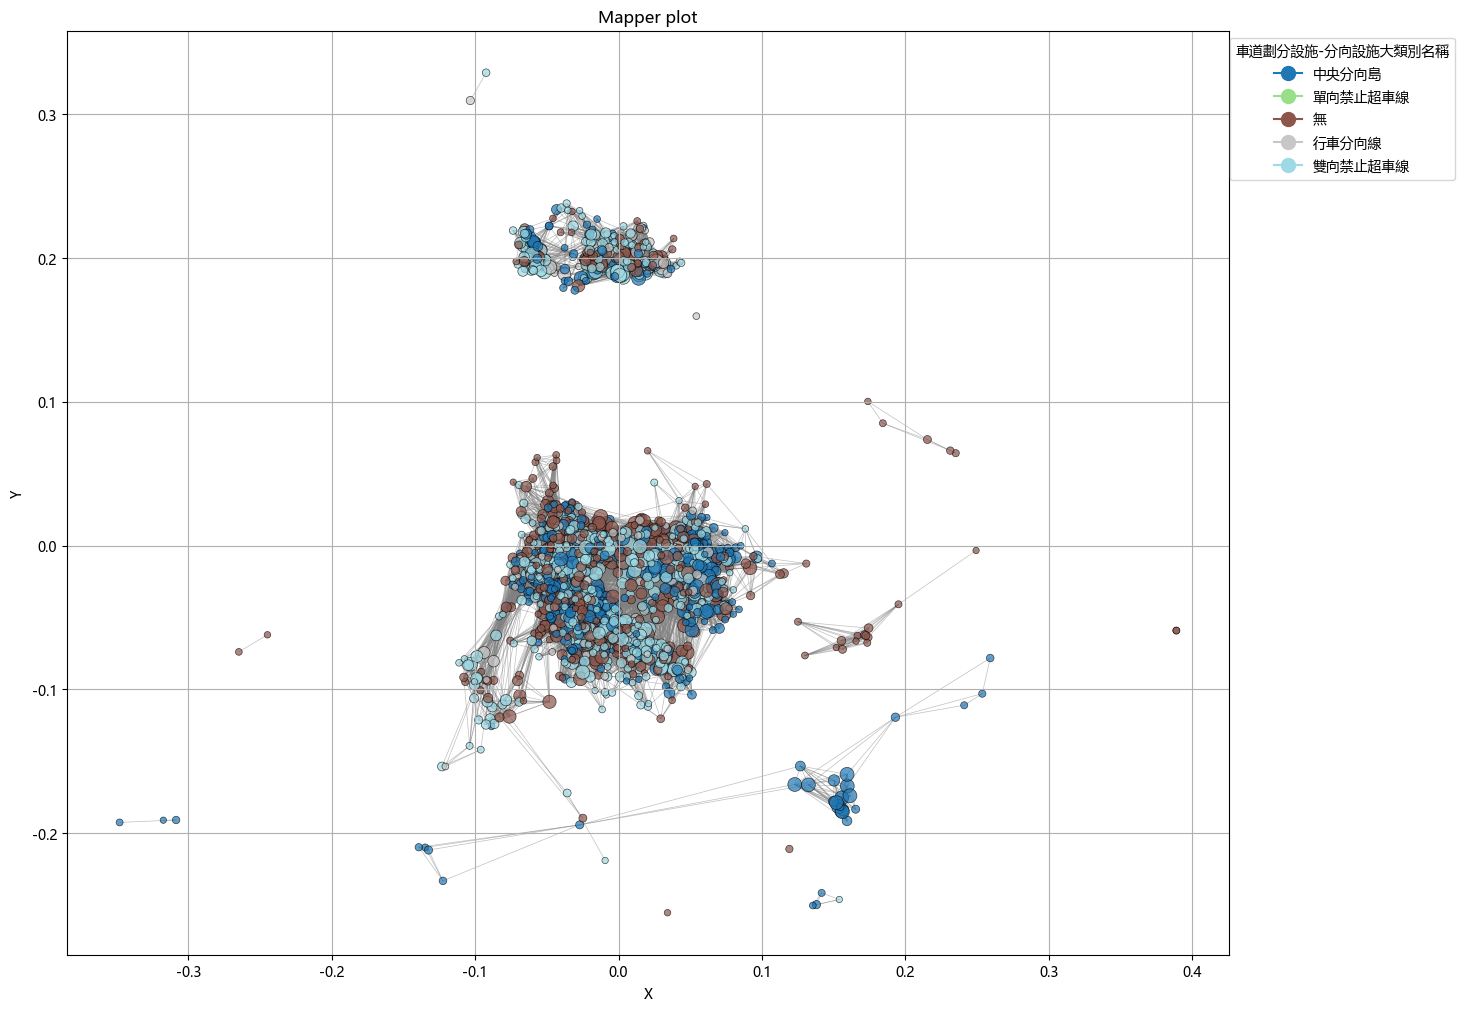

In [92]:
choose = '車道劃分設施-分向設施大類別名稱'
# choose = '死亡'

unique_categories = rbind_data[choose].dropna().unique()
unique_categories.sort()

# 統一顏色
color_palette = get_cmap("tab20", len(unique_categories))
color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[9][0], 
                            rbind_data, detailed_results_df)
mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
mapper_plotter.extract_data()
mapper_plotter.map_colors(choose, color_mapping_fixed, size=20) # 篩選資料
mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, set_label=True, size=100) # 限制點的大小

In [ ]:
choose = '車道劃分設施-分向設施大類別名稱'
# choose = '死亡'

unique_categories = rbind_data[choose].dropna().unique()
unique_categories.sort()

for index in range(detailed_results_df.shape[0]):
# for index in range(1):
    # 統一顏色
    color_palette = get_cmap("tab20", len(unique_categories))
    color_mapping_fixed = {category: color_palette(i) for i, category in enumerate(unique_categories)}

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], 
                                rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, color_mapping_fixed, size=30) # 篩選資料
    mapper_plotter.plot(choose, unique_categories, color_palette, avg=False, 
                        set_label=True, size=100, # 限制點的大小
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Car/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")

In [11]:
import umap
from umap import plot
import time

c:\Users\USER\anaconda3\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
c:\Users\USER\anaconda3\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
c:\Users\USER\anaconda3\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)


n_neighbors越大越注重全局結構，5 到 50 ，5~15適合高維度<br/>
min_dist影響緊密程度，越大越稀疏，通常在0.0 到 0.5

In [ ]:
n_neighbors = [5, 15, 30, 50, 100]
min_dist_range = [0, 0.01, 0.05, 0.1, 0.5, 1]  # 0.1 to 0.5 inclusive with 5 steps

# for n_neighbors in n_neighbors_range:
for min_dist in min_dist_range:
    
    for n in n_neighbors:
        
        start_time = time.time()

        reducer = umap.UMAP(
            n_jobs=-1, 
            n_neighbors=n, 
            min_dist=min_dist, 
            n_components=2, 
            metric="hamming"
            )

        lens1_umap = reducer.fit(mapper_numpy)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(elapsed_time)

        umap.plot.points(lens1_umap, labels=rbind_data['道路型態大類別名稱'], background='black')
        plt.savefig(f"Version3/GridSearch/UMAP/Car/UMAP_n{n}_d{min_dist:.2f}.png")